In [59]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [17]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/potato_disease/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2162 files belonging to 3 classes.


In [56]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

In [10]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 2 0 1 2 0 1 0]


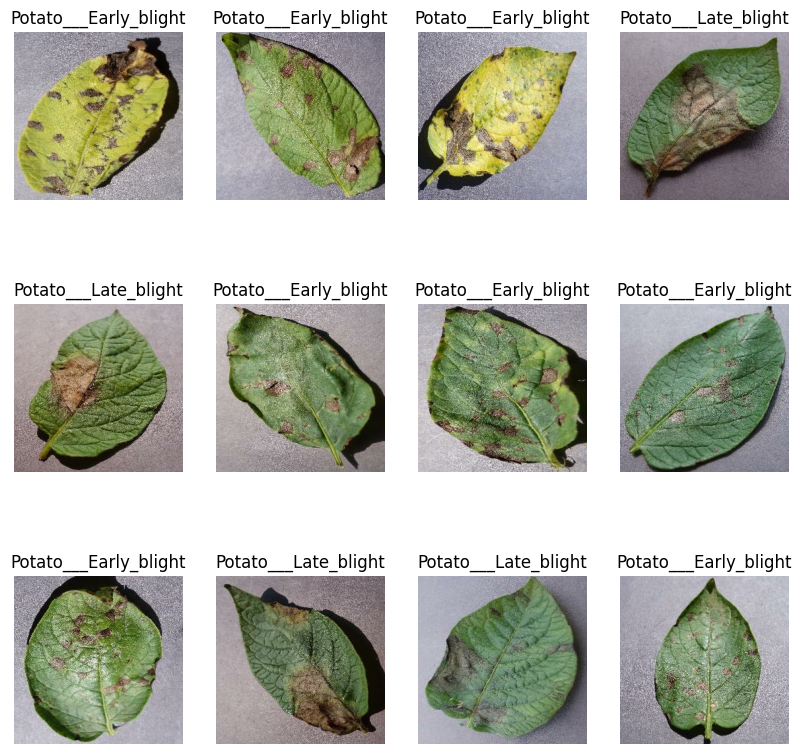

In [16]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_name[label_batch[i]])
    plt.axis('off')

In [24]:
train_ratio = 0.8
test_ratio = 0.1
print(len(dataset)*train_ratio)
print(len(dataset)*test_ratio)

54.400000000000006
6.800000000000001


In [27]:
import math
train_size = math.floor(len(dataset)*train_ratio)
test_size = math.ceil(len(dataset)*test_ratio)
print(train_size)
print(test_size)

54
7


In [23]:
train_ds = dataset.take(train_size)
len(train_ds)

54

In [28]:
test_ds = dataset.skip(train_size).take(test_size)
len(test_ds)

7

In [29]:
val_ds = dataset.skip(train_size + test_size)
len(val_ds)

7

In [30]:
def get_dataset_partitions_tf(ds, train_ratio=0.8, test_ratio=0.1, val_ratio=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(dataset)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  import math
  train_size = math.floor(len(dataset)*train_ratio)
  test_size = math.ceil(len(dataset)*test_ratio)

  train_ds = ds.take(train_size)
  test_ds = ds.skip(train_size).take(test_size)
  val_ds = ds.skip(train_size + test_size)

  return train_ds, test_ds, val_ds

In [32]:
train_ds, test_ds, val_ds = get_dataset_partitions_tf(dataset)

In [33]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

54
7
7


In [34]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [36]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [37]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [43]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 474s 4s/step - loss: 0.9099 - accuracy: 0.4589 - val_loss: 0.8286 - val_accuracy: 0.6071
Epoch 2/50
54/54 [==============================] - 227s 4s/step - loss: 0.7516 - accuracy: 0.6510 - val_loss: 0.6270 - val_accuracy: 0.7188
Epoch 3/50
54/54 [==============================] - 220s 4s/step - loss: 0.5686 - accuracy: 0.7512 - val_loss: 0.6884 - val_accuracy: 0.6607
Epoch 4/50
54/54 [==============================] - 222s 4s/step - loss: 0.4763 - accuracy: 0.7847 - val_loss: 0.4305 - val_accuracy: 0.8214
Epoch 5/50
54/54 [==============================] - 223s 4s/step - loss: 0.3630 - accuracy: 0.8547 - val_loss: 0.3894 - val_accuracy: 0.8304
Epoch 6/50
54/54 [==============================] - 226s 4s/step - loss: 0.2726 - accuracy: 0.8987 - val_loss: 0.3556 - val_accuracy: 0.8438
Epoch 7/50
54/54 [==============================] - 215s 4s/step - loss: 0.3449 - accuracy: 0.8559 - val_loss: 0.3355 - val_accuracy: 0.8616
Epoch 8/50
54

In [45]:
score = model.evaluate(test_ds)

7/7 [==============================] - 7s 985ms/step - loss: 0.2302 - accuracy: 0.9375


In [46]:
history

In [47]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [48]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

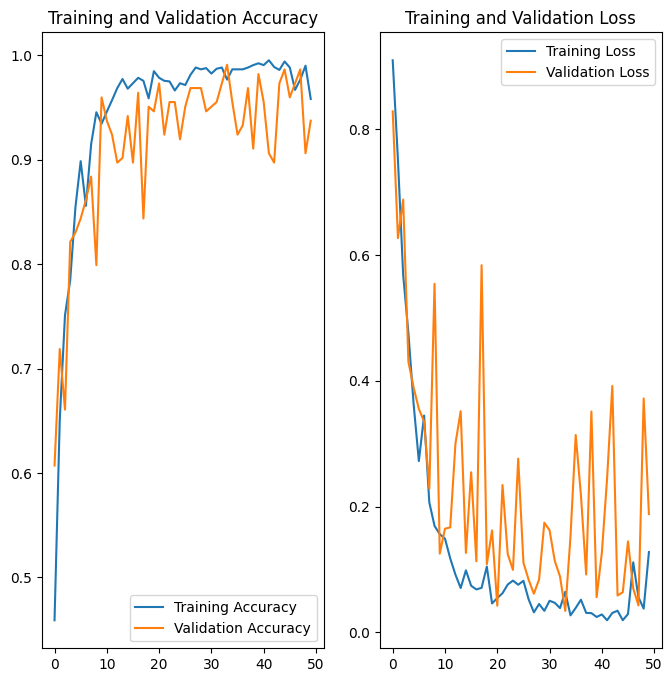

In [51]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
Actual Label:  Potato___Late_blight
1/1 [==============================] - 2s 2s/step
Predicted Label:  Potato___Late_blight


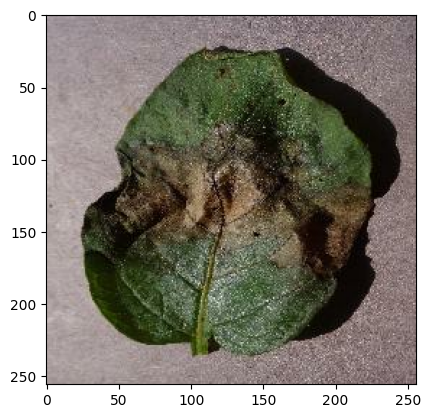

In [60]:
for image_batch, labels_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print('Actual Label: ', class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print('Predicted Label: ', class_names[np.argmax(batch_prediction[0])])

In [61]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

In [62]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f'Actual: {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}%')

    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [63]:
model_version=1
model.save(f'/content/drive/MyDrive/potato_disease/models{model_version}')

In [ ]:
#helps in updating model version
'''
import os
model_version=max([int(i) in os.listdr("/content/drive/MyDrive/potato_disease/models") + [0]]) + 1
model.save(f'/content/drive/MyDrive/potato_disease/models{model_version}')
'''